## Atomic and Ionic Cross Sections

In this tutorial, we make atomic and ionic cross sections and overplot them to see the differences. We strongly recommend reading the [Quick Start](https://cthulhu-xsec.readthedocs.io/en/latest/content/notebooks/quick_start.html) guide if you have not done so yet.

### VALD3 Database
Unlike the ExoMol, HITRAN, and HITEMP databases, the atomic line lists from the VALD database require you to sign up on the VALD website. The line lists must be requested manually through the website and then processed using the scripts provided in Cthulhu.

#### Part 1: Downloading Line Lists
The steps to register and download VALD line lists are very simple and detailed below. 
1. Go to the [VALD Website](http://vald.astro.uu.se/~vald/php/vald.php?docpage=contact.html).
2. If you are a new user, click on 'Contact form' on the left sidebar, and follow the instructions to register.
3. Once you are accepted as a user, login using your credentials.
4. On the top, click 'Extract Element'
5. Click 'Unit Selections' and select:
   * Energy level units: cm-1
   * Give wavelenths in medium: vacuum
   * Wavelength units: cm-1
   * Van der Waals syntax: Default
   * Isotopic scaling: On
   * click Save settings
6. You should be looking at a form that allows you to set various parameters for the line list. Set the following parameters for our tutorial:
   * Starting wavelength: 400
   * Ending wavelength: 500000
   * Element [+ionization]: Ca
   * Extraction format: long
   * Retrieve data via: FTP
   * Do not check off the circles for any optional parameters. This includes HFS splitting, the 3 damping constants, Land√© factor, and term designation.
   * Linelist configuration: Default
    
This will download the neutral calcium cross section from VALD. We will also need the line list for the Ca+ ion. To download that, do the same steps above, except enter 'Ca 2' for the element. In the VALD database, the first ionized state of an element starts with 2. So neutral calcium is Ca 1, Ca+ is Ca 2, etc.

#### Part 2: Processing Line Lists for use with Cthulhu
The line list downloaded from VALD must be processed before it can be used in cross section calculations. There are two easy steps to follow:

First, unzip/extract the file if you have not done so. Then, rename your downloaded file to ATOM_IONIZATION_'VALD.trans'. For example, if you downloaded neutral calcium, you would rename the file to 'Ca_I_VALD.trans', or Ca+ would be 'Ca_II_VALD.trans'. 

Second, call `process_VALD_file` from `VALD.py`, specifying the species, ionization state, and location of the renamed line list. We recommend adding your .trans file to a VALD data directory at the top directory level of the package. In this case, the function call would look something like:

`process_VALD_file(species = 'Ca', ionization_state = 1, VALD_data_dir = './VALD_Line_Lists/)`

Please note that the final forward slash in the `VALD_data_dir` argument **is necessary**.
    
This will create another .trans file in the same folder as the original. The name will be ATOM_IONIZATION.trans (i.e. Ca_I.trans). It will also convert this new .trans file into a HDF5 format (i.e. Ca_I.h5). This HDF5 file is what is used by Cthulhu in the cross section computation. **Make sure that this new .h5 file is in the same directory as the 'Atomic_partition_functions.pf' file that we provide.**

### Creating Ca I and Ca II Cross Sections
Let's create a cross section for the Ca I [neutral calcium] and Ca II [Ca+] ions. We start by "downloading" the Ca I and Ca II line lists. This was largely done in the last section, but calling the `summon` function just ensures that all the files are in the correct directories for Cthulhu to read.

We require the usual parameters `species` and `database` in the `summon` function. In addition, the parameter `VALD_data_dir` must be included. This parameter specifies the local folder which contains the downloaded atomic line lists from VALD. Since our folder (called 'VALD_Line_Lists' is included at the same directory level as this python file, we simply set this value to './VALD_Line_Lists/'). Note that the final forward slash **is necessary**.

For Ca II, we must additionaally specify the parameter `ionization_state = 2`, to indicate that we want the Ca II ion, and not the neutral state of the atom. If `ionization_state` is not specified, it defaults to 1. For clarity, we have specified it in both calls to the `summon` function below.

In [1]:
from Cthulhu.core import summon

species = 'Ca'

database = 'VALD'

# Process Ca I line list
summon(database=database, species = species, VALD_data_dir='./VALD_Line_Lists/', ionization_state = 1)

# Process Ca II line list
summon(database=database, species = species, VALD_data_dir='./VALD_Line_Lists/', ionization_state = 2)



 ***** Processing requested data from VALD. You have chosen the following parameters: ***** 

Atom: Ca 
Ionization State: 1

Line list ready.


 ***** Processing requested data from VALD. You have chosen the following parameters: ***** 

Atom: Ca 
Ionization State: 2

Line list ready.



Next, we compute the cross sections using both line lists, specifying the usual parameters `species`, `database`, `P`, `T`, and `input_directory`. For the Ca II cross section, we must again specify `ionization_state = 2`.

In [3]:
from Cthulhu.core import compute_cross_section

P = 1.0                         # Pressure in bars
T = 1000.0                      # Temperature in Kelvin
input_directory = './input/'    # Top level directory containing line lists

# Make Ca I cross section
compute_cross_section(database=database, species = species, pressure = P,
                      temperature = T, input_dir = input_directory, 
                      ionization_state = 1,
                      )

# Make Ca II cross section
compute_cross_section(database=database, species = species, pressure = P,
                      temperature = T, input_dir = input_directory, 
                      ionization_state = 2,
                      )

Beginning cross-section computations...
Loading VALD format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 2.8847074579971377 s
Pre-computation steps complete
Generating cross section for Ca I at P = 1.0 bar, T = 1000.0 K
Calculation complete!
Completed 20493 transitions in 0.19267476599634392 s

Total runtime: 4.653372884000419 s
Beginning cross-section computations...
Loading VALD format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 0.2243308250035625 s
Pre-computation steps complete
Generating cross section for Ca II at P = 1.0 bar, T = 1000.0 K
Calculation complete!
Completed 1956 transitions in 0.014195831994584296 s

Total runtime: 1.7354280369982007 s


Now we are able to plot the cross section. We need to first read the cross section files and add the cross sections to a collection. 

In [4]:
from Cthulhu.misc import read_cross_section_file, cross_section_collection

# Read in cross section for Ca I
nu, sigma = read_cross_section_file(species = species, database = database, ionization_state = 1,
                                    filename = 'Ca_I_T1000.0K_log_P0.0_H2-He_sigma.txt')

# Read in cross section for Ca II
nu2, sigma2 = read_cross_section_file(species = species, database = database, ionization_state = 2,
                                      filename = 'Ca_II_T1000.0K_log_P0.0_H2-He_sigma.txt')

# Generate an empty collection object for plotting
cross_sections = []

# Add first cross section to collection
cross_sections = cross_section_collection(new_x = nu, new_y = sigma, collection = cross_sections)

# Add second cross section to collection, making sure to specify the previous collection as a parameter
cross_sections = cross_section_collection(new_x = nu2, new_y = sigma2, collection = cross_sections)

And finally we plot the results. In addition to the usual required parameters `collection`, `labels`, and `filename`, we have added the parameters `x_min`, `x_max`, and `y_min` to view a zoomed in section of our plot. Note that `x_min` and `x_max` are in $\mu m$ while `y_min` is in $cm^{2}$.

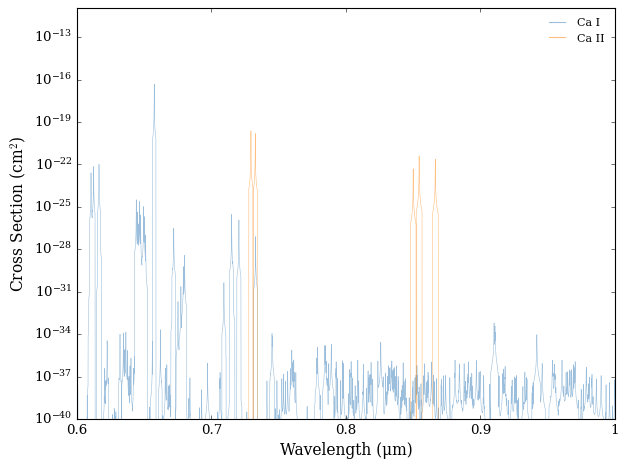

In [5]:
from Cthulhu.plot import plot_cross_section

plot_cross_section(collection = cross_sections, 
                   labels = ['Ca I', 'Ca II'], 
                   filename = 'Different_Ionization_States_of_Ca',
                   x_min = 0.6, x_max = 1.0, 
                   y_min = 1e-40,
                   x_axis_scale = 'linear',    # Linear wavelength axis instead of the default log axis
                   )